# Week 5
Last week's version included a simple battery class, market class, and a basic Q-learning implementation. 
In this week's version I will: 
- Extend the battery class with an `idle`-action and battery **efficiency**.
- Extend the market class with **more prices** and **real price data**.
- Use **linear programming** the see if last week's solution of the agent on the sine wave pricing was actually correct.
- Plot some curves to **visualize how the agent learns** and **find better hyperparameters**.

This notebook implements efficiency in the battery and randomness of SOC.

# 1. Use DAM prices

## 1.1 DayAheadMarket class

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Market:
    def __init__(self, duration_hours=24, timestep_minutes=15, pattern="square", high_price=10, low_price=-10, price_levels_num=10):
        if not (low_price < high_price):
            raise ValueError("Lowest price must be lower than highest price.")
        self.duration_hours = duration_hours
        self.timestep_minutes = timestep_minutes
        self.pattern = pattern
        self.high_price = high_price
        self.low_price = low_price
        self.num_steps = int(duration_hours * 60 / timestep_minutes)
        self.price_levels_num = price_levels_num
        self.prices, self.prices_discrete = self._generate_prices()

    def reset(self):
        self.prices, self.prices_discrete = self._generate_prices()
    
    def _generate_prices(self):
        if self.pattern == "square":
            prices = self._generate_square_wave()
        elif self.pattern == "sinus":
            prices = self._generate_sinus_wave()
        else:
            raise ValueError(f"Unknown pattern type: {self.pattern}")
    
        # Discretize prices
        levels = np.linspace(self.low_price, self.high_price, self.price_levels_num)
        prices_discrete = np.round(
            np.array([levels[np.argmin(np.abs(levels - p))] for p in prices]), 2
        )
    
        return prices, prices_discrete
    
    def _generate_square_wave(self):
        prices = []
        toggle = random.choice([self.high_price, self.low_price])
        i = 0
        while i < self.num_steps:
            block_length = random.randint(2, 16) # how many timesteps this block lasts
            for _ in range(block_length):
                if i >= self.num_steps:
                    break
                prices.append(toggle)
                i += 1
            toggle = self.high_price if toggle == self.low_price else self.low_price
        return np.array(prices)
    
    def _generate_sinus_wave(self):
        x = np.linspace(0, 2 * np.pi * (self.duration_hours / 6), self.num_steps, endpoint=False)
        mid = (self.high_price + self.low_price) / 2
        amplitude = (self.high_price - self.low_price) / 2
        prices = mid + amplitude * np.sin(x)
        return prices
    
    def plot(self):
        x = range(len(self.prices))
        plt.step(x, self.prices, label="Real Prices")
        plt.step(x, self.prices_discrete, label="Discrete Prices", alpha=0.6)
        plt.title("Imbalance Market Prices")
        plt.xlabel(f"Timestep ({self.timestep_minutes} min each)")
        plt.ylabel("Price")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.show()


class DayAheadMarket:
    def __init__(self, filename, price_levels_num = 100):
        self.filename = filename
        self.price_levels_num = price_levels_num
        self.days = self._load_data()
        self._discretize_prices()

    def get_prices(self):
        return [price for day in self.days for price in day]

    def _load_data(self):
        df = pd.read_csv(
            self.filename,
            sep=":",
            header=None,
            names=["hour", "price_raw"],
            engine="python"
        )
        df["price"] = df["price_raw"].str.replace(",", ".", regex=False).astype(float)
        df["hour"] = df["hour"].astype(int)

        days = []
        current_day = []
        for _, row in df.iterrows():
            current_day.append(row["price"])
            if len(current_day) == 24:
                days.append(current_day)
                current_day = []
        if current_day:
            days.append(current_day)
        return days

    def _discretize_prices(self):
        """Discretize prices for all days into `price_levels_num` levels."""
        all_prices = [price for day in self.days for price in day]
        self.low_price = min(all_prices)
        self.high_price = max(all_prices)
        levels = np.linspace(self.low_price, self.high_price, self.price_levels_num)
        
        self.days = [
            [round(float(levels[np.argmin(np.abs(levels - p))]), 2) for p in day]
            for day in self.days
        ]

    def __repr__(self):
        all_prices = [price for day in self.days for price in day]
        avg_price = sum(all_prices) / len(all_prices)
        min_price = min(all_prices)
        max_price = max(all_prices)
        return (
            f"HourlyPriceData('{self.filename}')\n"
            f"  Days: {len(self.days)}\n"
            f"  Price Levels: {self.price_levels_num}\n"
            f"  Average Price: {avg_price:.2f}\n"
            f"  Min Price: {min_price:.2f}\n"
            f"  Max Price: {max_price:.2f}"
        )

    def plot(self, day_index: int = 0):
        if day_index >= len(self.days):
            raise IndexError("Day index out of range.")
        plt.figure(figsize=(8, 4))
        plt.plot(range(24), self.days[day_index], marker="o")
        plt.title(f"Hourly Prices - Day {day_index + 1}")
        plt.xlabel("Hour")
        plt.ylabel("Price")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


## 1.2 Battery class (extended with efficiency)

In [2]:
class Battery:    
    def __init__(self, soc=15, capacity=30, power=5, efficiency=0.9):
        if not (0 <= soc <= capacity):
            raise ValueError("SOC must be between 0 and capacity.")
        self.soc = soc # kWh
        self.capacity = capacity # kWh
        self.power = power # kW
        self.efficiency = efficiency
        self.history = [] # list of (soc, time, action)

    def get_soc(self):
        return self.soc

    def charge(self, duration=15):
        """
        Charge the battery (duration in minutes).
        """
        self.history.append((self.soc, duration, 2))
        energy_from_grid = self.power * (duration / 60)
        energy_stored = energy_from_grid * self.efficiency
        soc_before = self.soc
        self.soc = min(self.capacity, self.soc + energy_stored)
        # If SOC gets saturated...
        actual_stored = self.soc - soc_before
        actual_used = actual_stored / self.efficiency
        return actual_used
    
    def idle(self, duration=15):
        """Idle the battery (duration in minutes)."""
        self.history.append((self.soc, duration, 1))
        return 0.0

    def discharge(self, duration=15):
        """Discharge the battery (duration in minutes).
        Returns: energy delivered to the grid.
        """
        self.history.append((self.soc, duration, 0))
        energy_possible = self.power * (duration / 60)
        soc_before = self.soc
        energy_removed = min(self.soc, energy_possible) # limited by SOC
        self.soc -= energy_removed
        energy_to_grid = energy_removed * self.efficiency
        return -energy_to_grid
    
    def get_history(self):
        return self.history

    def reset(self, soc=15):
        if not (0 <= soc <= self.capacity):
            raise ValueError("SOC must be between 0 and capacity.")
        self.history = []
        self.soc = soc

    def __repr__(self):
        return f"Battery(SOC={self.soc:.2f}/{self.capacity} kWh with efficiency: {self.efficiency})"

## 1.3 Q-learning setup

### Environment parameters + Q-learning hyperparameters

In [3]:
import dataclasses
from dataclasses import dataclass

@dataclass
class Config:
    timestep_min = 15
    duration_hours=24
    capacity = 30
    power = 5
    efficiency = 0.8
    price_levels_num = 100
    high_price = 10
    low_price = -10
    pattern = "sinus"
    
    # Q-learning
    alpha = 0.05
    gamma = 0.95
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay_steps = 500
    n_episodes = 1000

def random_soc(cfg):
    return random.randint(0, cfg.capacity)

cfg = Config()

### Battery and market

Battery(SOC=29.00/30 kWh with efficiency: 0.8)


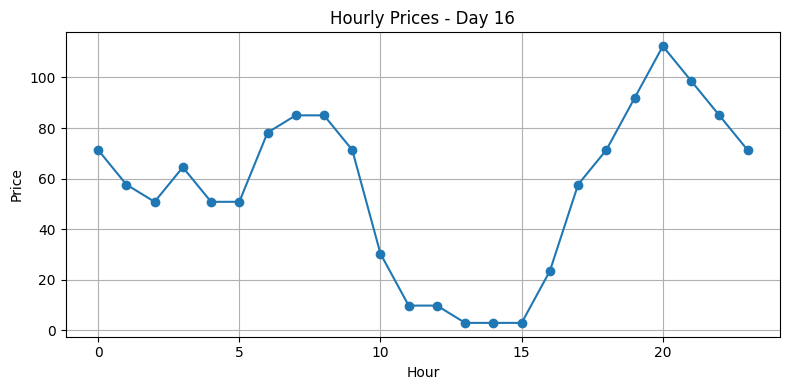

HourlyPriceData('merged.csv')
  Days: 120
  Price Levels: 100
  Average Price: 60.03
  Min Price: -462.33
  Max Price: 215.00
[[57.64, 57.64, 43.96, 43.96, 43.96, 43.96, 43.96, 43.96, 30.27, 9.75, -3.93, -44.99, -99.72, -106.56, -120.24, -86.04, -31.3, 2.91, 30.27, 64.48, 64.48, 57.64, 50.8, 37.12], [23.43, 23.43, 16.59, 16.59, 16.59, 23.43, 50.8, 64.48, 57.64, 30.27, 16.59, 9.75, 9.75, 2.91, 2.91, 2.91, 2.91, 37.12, 50.8, 64.48, 71.32, 78.17, 64.48, 57.64]]


In [4]:
battery = Battery(soc=random_soc(cfg), capacity=cfg.capacity, power=cfg.power, efficiency=cfg.efficiency)
market = DayAheadMarket(filename="merged.csv", price_levels_num=cfg.price_levels_num)
print(battery)
market.plot(day_index=15)
print(market)
print(market.days[0:2])

### Epsilon schedule

In [5]:
def epsilon_by_step(step, cfg):
    # Linear decay from start -> end over cfg.epsilon_decay_steps global steps
    frac = 1.0 - step / float(cfg.epsilon_decay_steps)
    frac = max(0.0, min(1.0, frac))  # clip to [0,1]
    return cfg.epsilon_end + (cfg.epsilon_start - cfg.epsilon_end) * frac

### Q-learning setup

In [6]:
from enum import IntEnum

class Action(IntEnum):
    IDLE = 0
    CHARGE = 1
    DISCHARGE = 2
    
n_states = (cfg.capacity + 1) * cfg.price_levels_num * (24)
Q = np.zeros((n_states, len(Action)))

possible_prices = np.unique(market.get_prices())
price_to_index = { price:index for index,price in enumerate(possible_prices) }

def state_to_index(soc, price, hour):
    soc_bin = int(round(soc))
    price_index = price_to_index[price]
    return soc_bin + (cfg.capacity + 1) * price_index + ( (cfg.capacity + 1) * cfg.price_levels_num ) * hour

In [7]:
def step(hour_index, day_index, action):
    price = market.days[day_index][hour_index]
    reward = 0.0
    if action == Action.DISCHARGE:
        delivered = -battery.discharge(duration=cfg.timestep_min)
        reward = price * delivered
    elif action == Action.IDLE:
        battery.idle(duration=cfg.timestep_min)
        reward = 0.0
    else:
        stored = battery.charge(duration=cfg.timestep_min)
        reward = -price * stored
    next_index = hour_index + 1
    return reward, next_index

### Q-Learning

In [8]:
episode_rewards = []
eps_hist = []
global_step = 0

for day in range(len(market.days)):
    battery.reset(soc=random_soc(cfg))
    h = 0
    s = state_to_index(battery.get_soc(), market.days[day][h], h)
    total_reward = 0
    while h < 24:
        epsilon = epsilon_by_step(global_step, cfg)
        if random.random() < epsilon:
            a = random.choice(list(Action))
        else:
            a = Action(int(np.argmax(Q[s])))

        r, h_next = step(h, day, a)
        total_reward += r

        if h_next < 24:
            s_next = state_to_index(battery.get_soc(), market.days[day][h_next], h_next)
            td_target = r + cfg.gamma * np.max(Q[s_next])
        else:
            s_next = None
            td_target = r
        
        Q[s, a] += cfg.alpha * (td_target - Q[s, a])
        s = s_next if s_next is not None else s
        h = h_next
        
        eps_hist.append(epsilon)
        global_step += 1
    episode_rewards.append(total_reward)

In [9]:
print("Q-table shape:", Q.shape)

Q-table shape: (74400, 3)


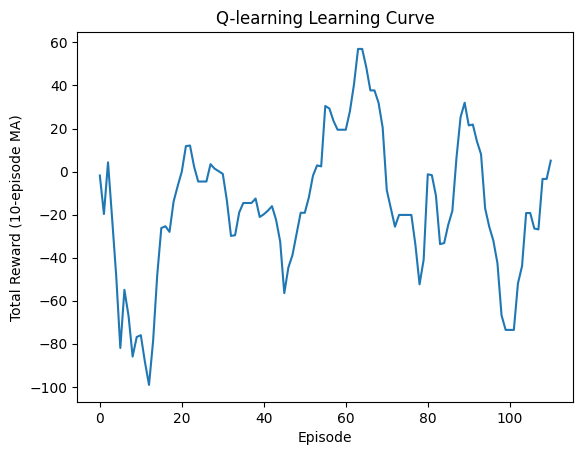

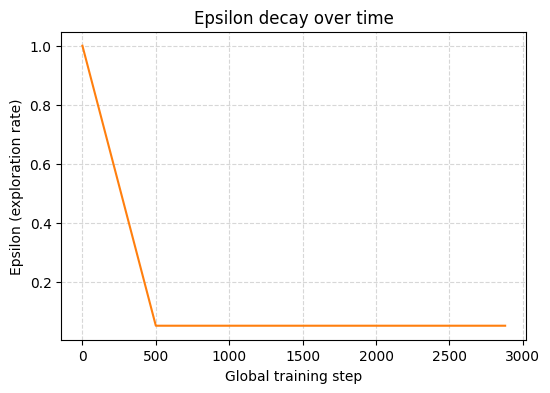

In [10]:
window = 10

plt.plot(np.convolve(episode_rewards, np.ones(window)/window, mode='valid'))
plt.xlabel("Episode")
plt.ylabel(f"Total Reward ({window}-episode MA)")
plt.title("Q-learning Learning Curve")
plt.show()

# --- Epsilon decay over steps ---
plt.figure(figsize=(6,4))
plt.plot(range(len(eps_hist)), eps_hist, color='tab:orange')
plt.xlabel("Global training step")
plt.ylabel("Epsilon (exploration rate)")
plt.title("Epsilon decay over time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 1.4 Test the agent

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actions(battery, market, timestep, initial_soc):
    """
    Plot prices and battery actions WITHOUT re-simulating SOC.
    Expands the recorded history into per-timestep samples by
    linearly interpolating from each block's start SoC to the next
    block's start SoC (last block held constant).
    """
    history = battery.get_history()  # [(soc_before, duration_min, action), ...]
    dt = timestep

    time_steps = []
    soc_history = []
    actions = []

    t = 0
    for i, (soc_start, duration_min, act) in enumerate(history):
        steps = max(1, int(round(duration_min / dt)))
        # Use next block's start SoC as the end value; hold flat for the last block
        soc_end = history[i + 1][0] if i + 1 < len(history) else soc_start

        for s in range(steps):
            alpha = s / steps  # 0 .. (steps-1)/steps
            soc_sample = soc_start + alpha * (soc_end - soc_start)
            time_steps.append(t)
            soc_history.append(soc_sample)
            actions.append(act)
            t += 1  # one sample per timestep

    # Align market prices to the sampling length
    if len(market.prices) >= len(time_steps):
        price_ts = market.prices[:len(time_steps)]
    else:
        fill = market.prices[-1] if len(market.prices) > 0 else 0
        price_ts = np.pad(market.prices, (0, len(time_steps) - len(market.prices)), constant_values=fill)

    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 4))
    ax2 = ax1.twinx()

    ax1.step(range(len(price_ts)), price_ts, where='post', color='tab:blue', linewidth=2,
             label='Market price [€/kWh]')
    ax1.set_ylabel('Price [€/kWh]', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2.plot(range(len(soc_history)), soc_history, color='tab:orange', label='Battery SOC (kWh)')
    ax2.set_ylabel('SOC (kWh)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Mark actions (label each type once)
    labeled = {0: False, 1: False, 2: False}
    for idx, act in enumerate(actions):
        if act is None:
            continue
        if act == 2:  # charge
            ax2.scatter(idx, soc_history[idx], color='green', marker='^', s=40,
                        label='Charge' if not labeled[2] else "")
            labeled[2] = True
        elif act == 0:  # discharge
            ax2.scatter(idx, soc_history[idx], color='red', marker='v', s=40,
                        label='Discharge' if not labeled[0] else "")
            labeled[0] = True
        elif act == 1:  # idle
            ax2.scatter(idx, soc_history[idx], color='gray', marker='o', s=30,
                        label='Idle' if not labeled[1] else "")
            labeled[1] = True

    ax1.set_title('Market prices and Battery actions over time')
    ax1.set_xlabel(f'Timestep (each = {dt} min)')
    ax1.grid(True, linestyle='--', alpha=0.4)

    fig.tight_layout()
    plt.show()


In [14]:
soc = random_soc(cfg)

battery.reset(soc=soc)
print(battery)
# market.reset()
total_profit = 0.0
day = random.randint(0, 119)
for h in range(24):
    s = state_to_index(battery.get_soc(), market.days[day][h], h)
    a = Action(int(np.argmax(Q[s])))
    r, _ = step(h, day, a)
    total_profit += r
print(f"One-day simulation profit: €{total_profit:.2f}")

# Plot results
# plot_actions(battery=battery, market=market, timestep=cfg.timestep_min, initial_soc=soc)

Battery(SOC=30.00/30 kWh with efficiency: 0.8)
One-day simulation profit: €0.00


## 3. Conclusion

Only at efficiency below 0.3 the agent starts showing weird behaviour. \
With the square price pattern this is only the case if the power is for example 5, but not when the power is 1.